# CIFAR-10 dataset classification with MLPs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem but using the Keras API (as included in the TensorFlow library)

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

2022-11-16 15:01:01.556415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 15:01:04.334271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 15:01:04.334326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 15:01:04.540200: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 15:01:06.932528: W tensorflow/stream_executor/platform/de

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

<img src="images/CIFAR-10.png"  align="left"/>

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

170498071/170498071 [==============================] - 2s 0us/step

CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (50000, 32, 32, 3)
y_train: (50000, 1)


### Download the dataset and load

In [3]:
!pip install image-dataset-loader
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!tar -xf cifar10.tgz

Defaulting to user installation because normal site-packages is not writeable
--2022-11-16 15:01:48--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.52.192
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.52.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz’

100%[======================================>] 135,107,811 56.1MB/s   in 2.3s   

2022-11-16 15:01:50 (56.1 MB/s) - ‘cifar10.tgz’ saved [135107811/135107811]



In [4]:
from image_dataset_loader import load
(x_train, y_train), (x_test, y_test) = load('cifar10', ['train', 'test'])

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (50000, 32, 32, 3)
y_train: (50000,)


This time we won't flatten the images upfront. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

<img src="images/image_representation.png"  align="left"/>

## Linear model

### Initialization

Let's begin with a simple linear model, but with the Keras library. First we use a `Flatten` layer to convert image data into vectors. 

A `Dense()` layer is a basic layer: $xW + b$ with an optional nonlinearity applied ("activation function"). The `Dense` layer connects each input to each output with some weight parameter. They are also called "fully connected."

Here we add a `Dense` layer that has $32\times32\times3=3072$ input nodes (one for each pixel in the input image) and 10 output nodes. 

In [5]:
class LinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)

        return x

We select *sparse categorical crossentropy* as the loss function, select [*stochastic gradient descent*](https://keras.io/optimizers/#sgd) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model. Note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *sgd*.

In [6]:
linear_model = LinearClassifier()

linear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

2022-11-16 15:04:19.096956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 15:04:19.097132: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 15:04:19.097233: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter02.mcp.alcf.anl.gov): /proc/driver/nvidia/version does not exist
2022-11-16 15:04:19.097814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Learning

Now we are ready to train our first model. An epoch means one pass through the whole training data.

Here is a concise way to train the network. The fit function handles looping over the batches. We'll see a more verbose approach in the next notebook that allows more performance tuning.

You can run the code below multiple times and it will continue the training process from where it left off. If you want to start from scratch, re-initialize the model using the code a few cells ago.

In [7]:
%%time
# This took about a third of a second per epoch on my laptop
batch_size = 512
epochs = 30
history = linear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
98/98 - 1s - loss: 2.1575 - accuracy: 0.2100 - 747ms/epoch - 8ms/step
Epoch 2/30
98/98 - 0s - loss: 1.9925 - accuracy: 0.2994 - 354ms/epoch - 4ms/step
Epoch 3/30
98/98 - 0s - loss: 1.9334 - accuracy: 0.3250 - 393ms/epoch - 4ms/step
Epoch 4/30
98/98 - 0s - loss: 1.8991 - accuracy: 0.3412 - 396ms/epoch - 4ms/step
Epoch 5/30
98/98 - 0s - loss: 1.8771 - accuracy: 0.3489 - 384ms/epoch - 4ms/step
Epoch 6/30
98/98 - 0s - loss: 1.8606 - accuracy: 0.3550 - 400ms/epoch - 4ms/step
Epoch 7/30
98/98 - 0s - loss: 1.8475 - accuracy: 0.3611 - 398ms/epoch - 4ms/step
Epoch 8/30
98/98 - 0s - loss: 1.8371 - accuracy: 0.3638 - 396ms/epoch - 4ms/step
Epoch 9/30
98/98 - 0s - loss: 1.8288 - accuracy: 0.3702 - 388ms/epoch - 4ms/step
Epoch 10/30
98/98 - 0s - loss: 1.8219 - accuracy: 0.3715 - 385ms/epoch - 4ms/step
Epoch 11/30
98/98 - 0s - loss: 1.8144 - accuracy: 0.3748 - 362ms/epoch - 4ms/step
Epoch 12/30
98/98 - 0s - loss: 1.8090 - accuracy: 0.3768 - 371ms/epoch - 4ms/step
Epoch 13/30
98/98 - 0s - 

In [8]:
print(linear_model.summary())

Model: "linear_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None


The summary shows that there are 30730 parameters in our model, as the weight matrix is of size 3072x10, plus there's a bias vector of 10x1.

Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data (100*accuracy is the percentage labeled correctly), so it should increase over time

Note that for either measure, we cannot fully trust the progress, as the model may have overfitted and just memorized the training data.

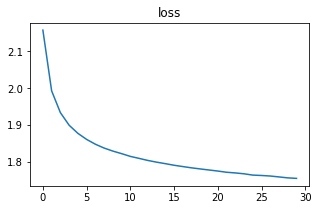

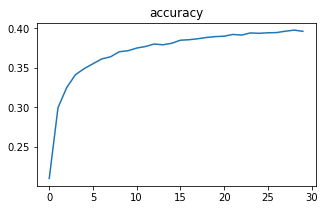

In [9]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [10]:
linscores = linear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (linear_model.metrics_names[1], linscores[1]*100))

313/313 - 1s - loss: 1.7659 - accuracy: 0.3926 - 550ms/epoch - 2ms/step
accuracy: 39.26%


We can now take a closer look on the results.

Let's define a helper function to show the failure cases of our classifier. 

In [11]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=20):
    rounded = numpy.argmax(predictions, axis=1)
    errors = rounded!=y_test.flatten()
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(x_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(x_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 20 test images the linear model classified to a wrong class:

313/313 [==============================] - 0s 1ms/step
Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


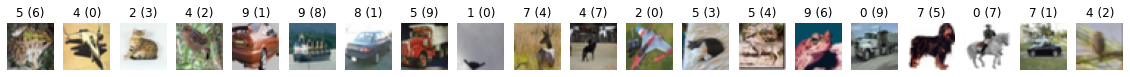

In [12]:
linpredictions = linear_model.predict(x_test)

show_failures(linpredictions)

## Multi-layer perceptron (MLP) network

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers. 

`Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting. 

There are two options below, a simple and a bit more complex model.  Select either one.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the groundtruth (`y_train`). 

In [13]:
class NonlinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(50, activation='relu')
        
        # A bit more complex model: (need to uncomment in call fn as well)
        self.layer_2 = tf.keras.layers.Dense(50, activation='relu')
        self.drop_3 = tf.keras.layers.Dropout(0.2)
        self.layer_4 = tf.keras.layers.Dense(50, activation='relu')
        self.drop_5 = tf.keras.layers.Dropout(0.2)
        
        # The last layer needs to be like this:
        self.layer_out = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)
        
        # The more complex version:
        x = self.layer_2(x)
        x = self.drop_3(x)
        x = self.layer_4(x)
        x = self.drop_5(x)
        
        x = self.layer_out(x)

        return x

Finally, we again `compile()` the model, this time using [*SGD*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [14]:
nonlinear_model = NonlinearClassifier()

nonlinear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

### Learning

In [15]:
%%time
# This took around a third of a second per epoch on my laptop for the simpler version, 
# and around 1 second per epoch for the more complex one.
batch_size = 512
epochs = 30
history = nonlinear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
98/98 - 1s - loss: 2.2621 - accuracy: 0.1535 - 969ms/epoch - 10ms/step
Epoch 2/30
98/98 - 0s - loss: 2.1844 - accuracy: 0.1862 - 414ms/epoch - 4ms/step
Epoch 3/30
98/98 - 0s - loss: 2.1348 - accuracy: 0.2047 - 406ms/epoch - 4ms/step
Epoch 4/30
98/98 - 0s - loss: 2.1023 - accuracy: 0.2182 - 428ms/epoch - 4ms/step
Epoch 5/30
98/98 - 0s - loss: 2.0739 - accuracy: 0.2290 - 491ms/epoch - 5ms/step
Epoch 6/30
98/98 - 1s - loss: 2.0491 - accuracy: 0.2443 - 604ms/epoch - 6ms/step
Epoch 7/30
98/98 - 1s - loss: 2.0292 - accuracy: 0.2492 - 519ms/epoch - 5ms/step
Epoch 8/30
98/98 - 0s - loss: 2.0112 - accuracy: 0.2615 - 459ms/epoch - 5ms/step
Epoch 9/30
98/98 - 0s - loss: 1.9903 - accuracy: 0.2720 - 420ms/epoch - 4ms/step
Epoch 10/30
98/98 - 1s - loss: 1.9742 - accuracy: 0.2768 - 700ms/epoch - 7ms/step
Epoch 11/30
98/98 - 1s - loss: 1.9588 - accuracy: 0.2839 - 513ms/epoch - 5ms/step
Epoch 12/30
98/98 - 0s - loss: 1.9440 - accuracy: 0.2895 - 492ms/epoch - 5ms/step
Epoch 13/30
98/98 - 1s -

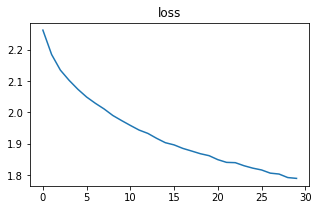

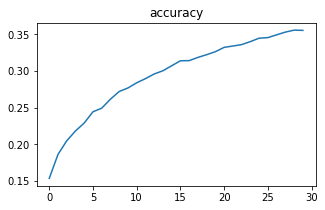

In [16]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

Accuracy for test data.  The model should be better than the linear model. 

In [17]:
%%time
scores = nonlinear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (nonlinear_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.7019 - accuracy: 0.4017 - 558ms/epoch - 2ms/step
accuracy: 40.17%
CPU times: user 1.15 s, sys: 299 ms, total: 1.45 s
Wall time: 754 ms


We can again take a closer look on the results, using the `show_failures()` function defined earlier.

Here are the first 20 test images the MLP classified to a wrong class:

313/313 [==============================] - 0s 1ms/step
Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


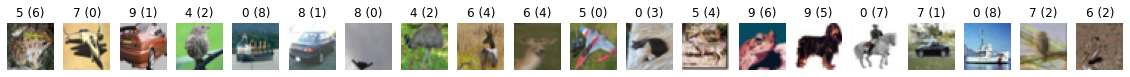

In [18]:
predictions = nonlinear_model.predict(x_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


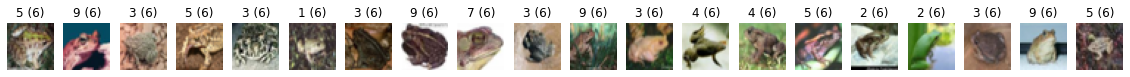

In [19]:
show_failures(predictions, trueclass=6)

We can also compute the confusion matrix to see which image get mixed the most, and look at classification accuracies separately for each class:

In [20]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[495  57  19  44  10  33  20  52 208  62]
 [ 50 566   4  31   6  48  27  31  75 162]
 [137  44 166  98 117 126 159  93  39  21]
 [ 56  63  59 221  23 303  96  87  35  57]
 [ 72  36 108  87 251  98 195  99  35  19]
 [ 46  35  67 149  43 419  93  90  37  21]
 [ 17  46  46 109 109 123 466  47  15  22]
 [ 52  62  43  89  79 107  62 393  25  88]
 [178  95   7  23   4  42   7  17 540  87]
 [ 54 208   6  33   4  17  30  53  95 500]]

Classification accuracy for each class:

0: 0.4950
1: 0.5660
2: 0.1660
3: 0.2210
4: 0.2510
5: 0.4190
6: 0.4660
7: 0.3930
8: 0.5400
9: 0.5000


In the next notebook, we'll introduce convolutional layers, which are commonly used for images.

# In-class exercise: improve the accuracy of this model

How can you improve model accuracy by increasing epochs, stacking more layers, or changing the optimizer?